<a href="https://colab.research.google.com/github/denniesbor/TwitterPython/blob/RawNotebooks/DataCleaning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Text Cleaning

Data cleaning is an essential step before any meaningful preprocessing. A custom data function will be designed to clean the harvested tweets. Tasks include: dropping duplicates, removing spammed tweets with adverts, and removing Swahili and English stopwords.


In [ ]:
# imports

import nltk
import spacy
import re

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from wordcloud import WordCloud
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

tokenizer = ToktokTokenizer()
from nltk.corpus import stopwords
nltk.download("stopwords")

nlp = spacy.load('en_core_web_sm')
from collections import Counter
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Cleaning Function

In [ ]:
# Define our own list of stopwords

my_stopwords = [
                '...','na','yeah','no','ya','kwa','niggah','nigga',
                'hapa','ni','Kenya','Kenyans','wa','fuck',
                'know', 'come', 'go', 'well', 'see', 'make', 'take', 'much', 
                'need', 'gt', 'hii', 'tu', 'nairobi', 'kama', 'sasa', 'and', 'must'
                ]

stopwrds = stopwords.words('english')

# Extend the nltk stopwords list
stopwrds.extend(my_stopwords)

# Text cleaning
def clean_text(text):
    
    """
    A function to clean the tweet text

    attributes
    ----------
    text: str
      input

    returns
    ----------
    text: str
      cleaned text

    """
    #Remove hyper links
    text = re.sub(r'&amp;','&',text)
    text = re.sub(r'https?:\/\/\S+', ' ', text)
    
    #Remove @mentions
    text = re.sub(r'@[A-Za-z0-9]+', ' ', text)
    
    #Remove anything that isn't a letter, number, or one of the punctuation marks listed
    text = re.sub(r"[^A-Za-z0-9]+", ' ', text)
    
    #Create NLP Document
    doc = nlp(text)
    
    # Tokenize the text and remove stopwords
    tokens = [word for word in [str(token.lemma_).strip() for token in doc] 
              if word != '-PRON-'] #and word not in stopwords
    
    filtered_text = ' '.join(tokens)  
    
    return filtered_text.lower()

In [ ]:
# read the dfs

df_1 = pd.read_csv('/content/drive/MyDrive/Summer2022/kenya_all_data.csv')
df_2 = pd.read_csv('/content/drive/MyDrive/Summer2022/kenya_politico.csv')

df_2.rename(columns={'text':'tweet_text'},inplace=True)

In [ ]:
df_1.head(5)

,tweet_id_str,date_time,location,tweet_text
0,1525264578468364290,2022-05-13 23:59:48+00:00,Kenya,Mr. Sherehe @clubtimba_eldoret for a #JoeMfa...
1,1525264548298731520,2022-05-13 23:59:41+00:00,Kenya,Mr. Sherehe @clubtimba_eldoret for a #JoeMfa...
2,1525264538530156544,2022-05-13 23:59:38+00:00,Misitu Raha (Achi's Ranch),You feel a little hornier when you call them b...
3,1525264505005015042,2022-05-13 23:59:30+00:00,Kenya,Mr. Sherehe @clubtimba_eldoret for a #JoeMfa...
4,1525264467122176002,2022-05-13 23:59:21+00:00,"Oyugis, Kenya",@Msoo37726387 Jesus is the King of Pease.\n#Ro...


In [ ]:
df_2.head(2)

,Unnamed: 0,date,author_id,tweet_id,tweet_text
0,0,2022-05-14 23:59:25+00:00,2942181101,1525626872113029120,Good morning Kenya 🇰🇪…..Main Reasons why Kenya...
1,1,2022-05-14 23:59:10+00:00,426949133,1525626808493801472,JIMMY KIBAKI speaks on ditching UHURU for DP R...


### Remove Ads and Blank Texts

In [ ]:
def remove_ads(df: pd.DataFrame):

  ''' Remove ads and clean the texts
  
  params
  --------
  df: dataframe

  returns
  -------
  df: cleaned df
  '''

  # filter tweets which are ads
  Adverts = df[df['tweet_text'].str.contains(r'contact \d*|free airtime|advert|available for |@ only kes|Contact 07\d+',re.I,regex=True)]

  # extract indices of the ads
  ads_indexes= [ad for ad in Adverts.index]

  # drop ad tweets
  df.drop(index=ads_indexes,inplace =True)

  # reset the indices and drop duplicates
  df.reset_index(drop=True,inplace=True)
  df.drop_duplicates(inplace=True)

  # apply the clean text function on the df
  df['tweet_text'] = df['tweet_text'].apply(clean_text)

  # extract the length of the tweets
  df['length_tweet'] = df['tweet_text'].apply(len)

  # strip the whitespaces in the texts
  df['tweet_text'].str.strip()

  # acquire the indices of the blanks
  blanks = []
  for i,text in enumerate(df['tweet_text']):
    if text == '':
      blanks.append(i)

  blank_df = df.iloc[blanks]
  
  # drop blanks
  df.drop(index=blanks,axis=0,inplace=True)


  return df

In [ ]:
df_1_clean = remove_ads(df_1)
df_2_clean = remove_ads(df_2)

In [ ]:
df_1_clean.shape


(13950, 5)

### Visualize the df_2 in a WordCloud

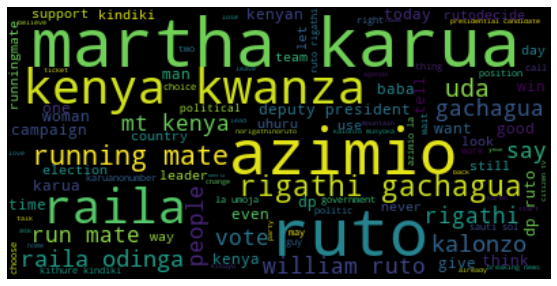

In [ ]:
tweets_ = ' '.join([text for text in df_2_clean['tweet_text']])
clean_words = []
for word in tweets_.split():
    if word not in stopwrds:
        clean_words.append(word)
word_cloud = WordCloud(max_font_size = 50,background_color='black',max_words=100).generate(' '.join(clean_words))

plt.figure(figsize = (10,5))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Visualize df_1 in a Word Cloud

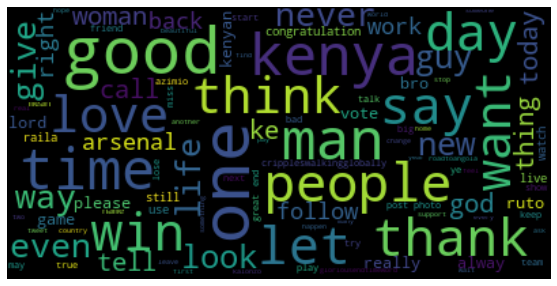

In [ ]:
tweets_ = ' '.join([text for text in df_1_clean['tweet_text']])
clean_words = []
for word in tweets_.split():
    if word not in stopwrds:
        clean_words.append(word)
word_cloud = WordCloud(max_font_size = 50,background_color='black',max_words=100).generate(' '.join(clean_words))

plt.figure(figsize = (10,5))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

The data frame texts are ready for further preprocessing. It's exported as CSV files for other NLP tasks.

In [ ]:
df_1_clean.to_csv('/content/drive/MyDrive/Summer2022/kenya_all_data_clean.csv', index=False)
df_2_clean.to_csv('/content/drive/MyDrive/Summer2022/kenya_politico_clean.csv', index=False)